In [403]:
import pandas as pd
import regex as re
import numpy as np
import math

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [404]:
df_coupe = pd.read_csv('car_list_coupe.csv')
df_sedan = pd.read_csv('car_list_sedan.csv').append(pd.read_csv('car_list_sedan2.csv'))
df_crossover = pd.read_csv('car_list_crossover.csv').append(pd.read_csv('car_list_crossover2.csv'))
df_pickup = pd.read_csv('car_list_pickup.csv')
df_luxury = pd.read_csv('car_list_luxury.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'car_list_coupe.csv'

In [410]:
df = df_coupe.append(df_sedan).append(df_crossover).append(df_pickup).append(df_luxury).reset_index()

In [411]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1293 entries, 0 to 1292
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   index                       1293 non-null   int64  
 1   Unnamed: 0                  1293 non-null   int64  
 2   Curb Weight                 777 non-null    object 
 3   Dimensions                  738 non-null    object 
 4   Drive Type                  1293 non-null   object 
 5   Driver Head Room            839 non-null    object 
 6   Driver Leg Room             839 non-null    object 
 7   Engine Type                 1293 non-null   object 
 8   Exterior/Interior Color     1293 non-null   object 
 9   Front Tire Size (standard)  839 non-null    object 
 10  Fuel Capacity               837 non-null    object 
 11  Horsepower                  837 non-null    object 
 12  MPG                         1152 non-null   object 
 13  Number of Keys              0 non

In [412]:
df['year'] = df['year-make'].map(lambda x: int(x[:4]))
df['torque'] = df['Torque (ft-lbs)'].dropna().map(lambda x: int(x[:x.find('t')-1]))
df['hrs_pwr'] =df['Horsepower'].dropna().map(lambda x: int(x[:x.find(' ')]))
df['mpg_city'] = df['MPG'].dropna().map(lambda x: int(x[:x.find(' ')]))
df['mpg_hwy'] = df['MPG'].dropna().map(lambda x: int(re.sub('[a-zA-Z\ ]|\(([0-9a-zA-Z])*\)','',x[x.find('/')+2:])))
df['log_mpg_hwy'] = np.log(df.mpg_hwy)
df['make'] = df['year-make'].map(lambda x: x[x.find(' ')+1:])
#df = df.join(pd.get_dummies(df.make, drop_first = True))
df = df.join(pd.get_dummies(df.Transmission, drop_first = True))
df['dmsn_cmbd'] =df.Dimensions.dropna().map(lambda x: math.prod([float(y) for y in re.sub('[^0-9\.]',' ',x).split()]))

In [413]:
cols = ['Curb Weight','Driver Head Room','Driver Leg Room','Fuel Capacity','Wheelbase','price', 'miles','torque']
for col in cols:
    df[col] = df[col].dropna().map(lambda x: x if type(x) == float else re.sub("[a-z,\$\*\"\ \-]",'',x.replace('K','000')))
    df[col] = df[col].dropna().map(lambda x: np.nan if x == '' else float(x))
    
df['log_miles'] = np.log(df['miles'])
df['log_model_age'] = np.log(2022 - df['year'])

lux_lst = ['Acura', 'Infiniti', 'Tesla','Jaguar','Lexus','Audi','BMW','Mercedes-Benz','Porsche', 'GMC', 'Ram']
def is_lux(cm):
    if cm in lux_lst:
        return 1
    else:
        return 0

df['is_luxury'] = df.make.dropna().map(is_lux)

In [414]:
def cat_drive_type(dt):
    nd = ''
    if '2WD' in dt:
        nd = '2WD'
    elif 'AWD' in dt:
        nd = 'AWD'
    else:
        nd = '4WD'
    
    return nd

df['drive_type'] = df['Drive Type'].dropna().map(cat_drive_type)
df = df.join(pd.get_dummies(df.drive_type, drop_first = True))
df['curb_null'] = df['Curb Weight'].fillna(0).map(lambda x: 0 if x == 0  else 1)
df['torque_null'] = df['torque'].fillna(0).map(lambda x: 0 if x == 0  else 1)
df = df.fillna(df.median())

<AxesSubplot:>

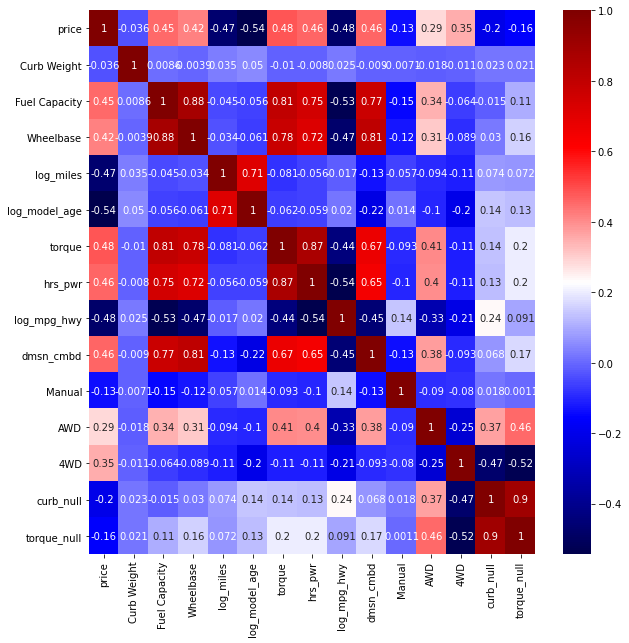

In [416]:
feats = ['price','Curb Weight','Fuel Capacity','Wheelbase','log_miles', 'log_model_age','torque','hrs_pwr','log_mpg_hwy','dmsn_cmbd','Manual', 'AWD','4WD','curb_null','torque_null']
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(df[feats].corr(), cmap = 'seismic', annot = True)

In [141]:
sns.pairplot(df[feats])

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f5d84958820> (for post_execute):


KeyboardInterrupt: 

In [9]:
def RMSE(actuals, preds): #root mean squared error
    return np.sqrt(np.mean((actuals - preds)**2))
def MAE(actuals, preds): #mean absolute error
    return np.mean(np.abs(actuals-preds))


In [10]:
def diagnostic_plots(y_pred, y_true):
    resid = y_pred - y_true
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    g1 = sns.regplot(x=y_pred, y=y_true, ci=False, fit_reg=False, line_kws={'color': 'blue'}, ax=axes[0], scatter_kws={'s': 5})
    g1.set_xlabel('Predicted Target')
    g1.set_ylabel('True Target')
    g1.plot(y_true, y_true, '--', color='gray')

    g2 = sns.regplot(x=y_pred, y=resid, lowess=True, ax=axes[1], line_kws={'color': 'red'}, scatter_kws={'s': 5})
    g2.set_xlabel('Predicted Target')
    g2.set_ylabel('Residual')
    g2.axhline(y=0, color='gray', linestyle='--')

    stats.probplot(resid, dist="norm", plot=axes[2])

    fig.suptitle('Diagnostic Plots');
    fig.tight_layout();



In [361]:
df.corr().price.sort_values(ascending = False)

price                 1.000000
year                  0.492472
torque                0.482479
dmsn_cmbd             0.460139
hrs_pwr               0.458194
Fuel Capacity         0.451803
Wheelbase             0.417081
4WD                   0.350954
is_luxury             0.331036
AWD                   0.285521
Passenger Capacity    0.188546
Driver Head Room      0.120499
Stock #               0.000584
Curb Weight          -0.035694
Driver Leg Room      -0.046888
dmsn_null            -0.111526
Manual               -0.134230
torque_null          -0.158461
Unnamed: 0           -0.162797
index                -0.162797
curb_null            -0.202935
mpg_city             -0.384318
miles                -0.422763
log_miles            -0.470388
mpg_hwy              -0.477550
log_mpg_hwy          -0.481099
log_model_age        -0.541032
Number of Keys             NaN
Name: price, dtype: float64

In [362]:
corr_mask = np.abs(df.corr().price) >= .2
price_mask = df.price <25000


df_fit = df[(corr_mask[corr_mask == True].index)].dropna()[price_mask]

X, y = df_fit.drop('price',axis=1), df_fit['price']
X, X_test, y, y_test  = train_test_split(X,y, test_size = .2,random_state = 99)
X, y = np.array(X), np.array(y)

In [363]:
df_fit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 658 entries, 1 to 1289
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Fuel Capacity  658 non-null    float64
 1   Wheelbase      658 non-null    float64
 2   miles          658 non-null    float64
 3   price          658 non-null    float64
 4   year           658 non-null    int64  
 5   torque         658 non-null    float64
 6   hrs_pwr        658 non-null    float64
 7   mpg_city       658 non-null    float64
 8   mpg_hwy        658 non-null    float64
 9   log_mpg_hwy    658 non-null    float64
 10  dmsn_cmbd      658 non-null    float64
 11  log_miles      658 non-null    float64
 12  log_model_age  658 non-null    float64
 13  is_luxury      658 non-null    int64  
 14  4WD            658 non-null    uint8  
 15  AWD            658 non-null    uint8  
 16  curb_null      658 non-null    int64  
dtypes: float64(12), int64(3), uint8(2)
memory usage: 83.5

In [364]:
alphalist = 10**(np.linspace(-2,2,200))

lm = LinearRegression()
lcv = LassoCV(alphas = alphalist)
rcv = RidgeCV(alphas = alphalist)

In [401]:
def kfold_cv_ols(X,y,n,model):
    kf = KFold(n_splits=n, shuffle=True, random_state = 99)
    cv_r2 = []
    
    for train_ind, val_ind in kf.split(X,y):
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 
    


        model.fit(X_train, y_train)
        cv_r2.append(model.score(X_val, y_val).round(3))
    return cv_r2

def kfold_cv_reg(X,y,n,model):
    kf = KFold(n_splits=n, shuffle=True, random_state = 99)
    cv_r2 = []

    for train_ind, val_ind in kf.split(X,y):
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 
    

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        model.fit(X_train_scaled, y_train)
        cv_r2.append(model.score(X_val_scaled, y_val).round(3))
    return cv_r2

In [393]:
lm_r2s = kfold_cv_ols(X,y,5,lm)
print('R2s:',lm_r2s,'Mean:',np.mean(lm_r2s),'Stdev:',np.std(lm_r2s))

R2s: [0.695, 0.68, 0.675, 0.506, 0.414] Mean: 0.5940000000000001 Stdev: 0.11340370364322323


In [395]:
lcv_r2s = kfold_cv_reg(X,y,5,lcv)
print('R2s:',lcv_r2s,'Mean:',np.mean(lcv_r2s),'Stdev:',np.std(lcv_r2s))

R2s: [0.695, 0.672, 0.667, 0.506, 0.431] Mean: 0.5942000000000001 Stdev: 0.10576086232628779


In [396]:
rcv_r2s = kfold_cv_reg(X,y,5,rcv)
print('R2s:',rcv_r2s,'Mean:',np.mean(rcv_r2s),'Stdev:',np.std(rcv_r2s))

R2s: [0.7, 0.681, 0.668, 0.504, 0.429] Mean: 0.5963999999999999 Stdev: 0.10915786732984481


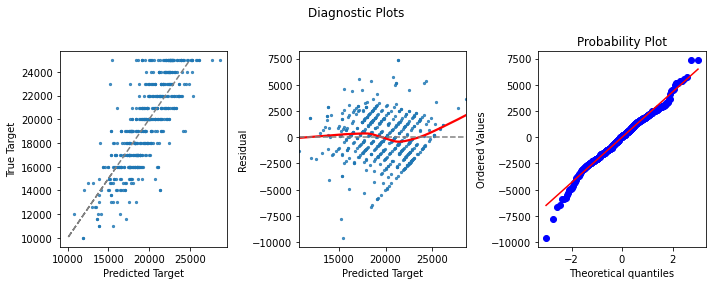

In [397]:
rcv.fit(X,y)
r2 = rcv.score(X,y)
y_pred = rcv.predict(X)

diagnostic_plots(y_pred,y)


In [399]:
MAE(y_pred,y)
RMSE(y_pred,y)

2165.5020455803565

In [319]:
resid =(y_pred-y)

In [320]:
range(50,100)

range(50, 100)

(array([  1.,   3.,  10.,  26., 119., 157., 143.,  52.,  12.,   3.]),
 array([-9592.86844136, -7898.17390911, -6203.47937685, -4508.7848446 ,
        -2814.09031235, -1119.3957801 ,   575.29875215,  2269.9932844 ,
         3964.68781665,  5659.3823489 ,  7354.07688116]),
 <BarContainer object of 10 artists>)

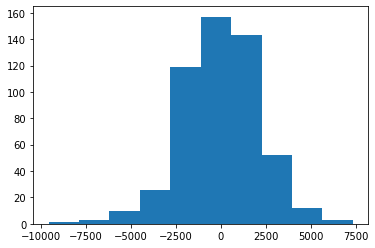

In [321]:
plt.hist(resid)

In [400]:
print(rcv.score(X_test,y_test))
y_pred_test =rcv.predict(X_test) 
MAE(y_pred_test, y_test)
RMSE(y_pred_test, y_test)

0.6203648721857092


1929.7424657959784

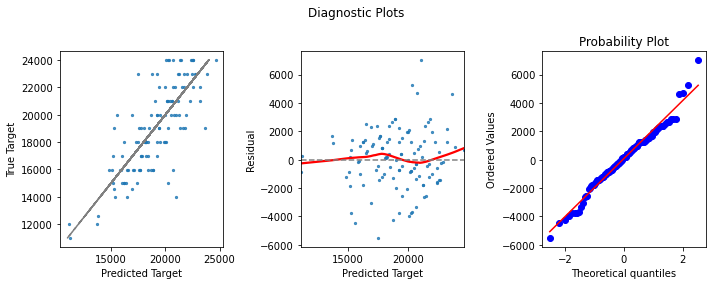

In [300]:
diagnostic_plots(y_pred_test,y_test)

,Unnamed: 0,index,Unnamed: 0.1,Curb Weight,Dimensions,Drive Type,Driver Head Room,Driver Leg Room,Engine Type,Exterior/Interior Color,...,Manual,dmsn_cmbd,log_miles,log_model_age,is_luxury,drive_type,4WD,AWD,curb_null,torque_null
0,0,0,0,2798.0,"166.7"" L x 69.9"" W x 50.6"" H","2WD, Rear Wheel Drive",37.1,41.9,"4-cyl, Gas, 2.0L",Blue/Black,...,1,589607.898,8.853665,1.386294,0,2WD,0,0,1,1
1,1,1,1,3501.0,"188.500"" L x 73.900"" W x 55.600"" H","2WD, Rear Wheel Drive",38.5,42.4,"6-cyl, Gas, 3.7L",Silver/Black,...,1,774516.340,11.302204,2.197225,0,2WD,0,0,1,1
2,2,2,2,3501.0,"188.5"" L x 73.9"" W x 55.8"" H","2WD, Rear Wheel Drive",38.5,42.4,"6-cyl, Gas, 3.7L",Black/Gray,...,0,777302.370,11.362103,2.079442,0,2WD,0,0,1,1
3,3,3,3,3834.0,"197.9"" L x 75.7"" W x 57.5"" H","2WD, Rear Wheel Drive",39.3,42.0,"6-cyl, Gas, 3.6L",Black/Black,...,0,861409.225,10.896739,1.791759,0,2WD,0,0,1,1
4,4,4,4,3502.0,NaN,4WD,39.5,42.0,"6-cyl, Gas, 3.6L",Gray/Black,...,0,811949.070,10.491274,1.098612,0,4WD,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1288,1288,105,105,3502.0,NaN,4WD,39.5,42.0,"8-cyl, Gas, 4.6L",Gray/Tan,...,0,811949.070,11.225243,1.945910,1,4WD,1,0,0,0
1289,1289,106,106,3502.0,NaN,2WD,39.5,42.0,"4-cyl, Turbo Gas, 1.8L",Black/Tan,...,0,811949.070,10.839581,2.079442,1,2WD,0,0,0,0
1290,1290,107,107,3502.0,NaN,2WD,39.5,42.0,"4-cyl, Turbo Gas, 2.0L",White/Black,...,0,811949.070,10.463103,1.386294,0,2WD,0,0,0,0
1291,1291,108,108,3502.0,NaN,2WD,39.5,42.0,"6-cyl, Gas, 3.6L",Gray/Black,...,0,811949.070,9.305651,1.386294,0,2WD,0,0,0,0
